In [2]:
%load_ext autoreload
%autoreload 2

TODO : 

- Corriger bug qui fait que c'est StarSat dans tout le stream et pas seulement dans le sous-stream (uniquement pour BHA-core, graphes ?)
- Retirer les valeurs en dur pour b,e et le langage
- Lancer :D
- Installer jupyter lab sur tiphaineviard.com ?
- Avoir un moyen de dessiner les interieurs etc. ?

# GoodReads Poetry dataset

The full dataset (including other genres) is available at: https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home. We focus here on the _Poetry_ dataset for tractability, as it is the one with the least number of books and reviews.

The files in the `./data/goodreads/` directory are:

- `goodreads_books_poetry.json` : contains information about the books (i.e. nodes)
- `reviews.json` : contains reviews of books by users, with the associated timestamp and ratings

Note that the number of reviews is significantly lower than the number of interactions; indeed, "interacting" on goodreads can be "shelving", posting a review, a rating, etc.

In [3]:
import ujson as json
import math
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

from lib.Stream import Stream, StreamStarSat
from datetime import datetime
from lib.Utils import Utils

# nltk.download("punkt")

DELTA = 3600

We isolate relevant words by TF-IDF (Term Frequency - Inverse Document Frequency) score. For a term i in a document d within corpus D, the the TF-IDF is:
$$
    TFIDF_D(i,d) = tf_{i,d} \cdot \log\left(\frac{|D|}{|\{d \in D : i\in d\}|}\right)
$$

In [4]:
def tf_idf(term, document, corpus):
    # TF
    count = 0
    for i in document:
        if i == term:
            count += 1
    frequency = count / len(document)
    # IDF
    df = 0
    for d in corpus:
        if term in set(d):
            df += 1
    return frequency * math.log10(len(corpus) / df)

In [5]:
a = "The car is driven on the road"
b = "The truck is driven on the highway"
corpus = [a,b]

In [6]:
reviews_file = open("data/goodreads/goodreads_reviews_poetry.json")
reviews = []
users = set()
books = set()
ratings = {} # sparse matrix ?
links = []

for (i,line) in enumerate(reviews_file):
    data = json.loads(line)
    
    # Transform date to timestamp
    date_added = datetime.strptime(data["date_added"], "%a %b %d %H:%M:%S %z %Y")
    date_added = date_added.timestamp()
    
    users.add(data["user_id"])
    books.add(data["book_id"])
    reviews.append(data["review_text"])
    
    u = data["user_id"]
    v = data["book_id"]

    b = date_added - DELTA
    e = date_added + DELTA
    link = {"b": b, "e": e, "u": u, "v": v, "label_u": "abc", "label_v": "bcd"}
    links.append(link)

In [7]:
s = Stream(lang_left=set("abc"), lang_right=set("bcd"))
s.add_links(links)

In [8]:
res_int = s.interior(s.V, s.V)

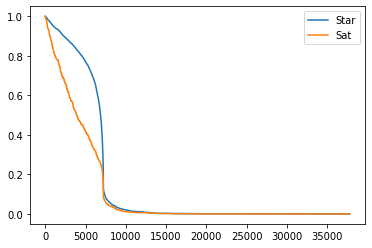

In [9]:
len(res_int[0]), len(res_int[1])
c = Utils.ccdf([ i[2]-i[1] for i in res_int[0] ])
c_2 = Utils.ccdf([ i[2]-i[1] for i in res_int[1] ])

plt.plot(c[0], c[1], label="Star")
plt.plot(c_2[0], c_2[1], label="Sat")
plt.legend()

In [10]:
vectorizer = TfidfVectorizer(use_idf=True)
res = vectorizer.fit_transform(reviews)

Total number of concepts (i.e. distinct words in reviews)

In [11]:
n_users, n_books, n_reviews, n_concepts = len(users), len(books), len(reviews), len(vectorizer.get_feature_names())
print(f"{n_users} users, {n_books} books, {n_reviews} reviews, {n_concepts} concepts (i.e. distinct words in reviews)")

47400 users, 36412 books, 154555 reviews, 403416 concepts (i.e. distinct words in reviews)


In [12]:
tfidf_values = [round(i, 3) for i in res.data]
len(tfidf_values)

9292775

In [13]:
ccdf_values = Utils.ccdf(tfidf_values)
import numpy as np
np.mean(tfidf_values)

0.09749984294250118

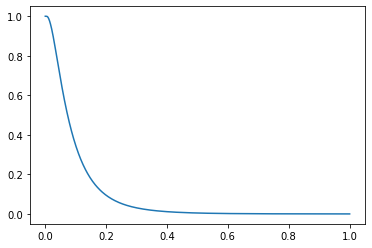

In [14]:
plt.plot(ccdf_values[0], ccdf_values[1])

In [15]:
def parse_review(text, threshold=0.0):
    print(vectorizer.get_feature_names()[143450:143550])

import pandas as pd

In [59]:
# vectorizer.get_feature_names()[i], for a given i, will output the associated word
# However, it's slow, and we don't really need it so far, so we keep to integers indices
filter_tfidf_scores = lambda r: [ (i, v) for i, v in enumerate(r) if v > 0.1 ]
filter_tfidf_scores = lambda r: r.eliminate_zeros() # [ (i, v) for i, v in enumerate(r) if v > 0.1 ]

words_per_review = []
for i, r in enumerate(res):
    if i % 10000 == 0:
        print(i)
    
    tfidf_scores = r.eliminate_zeros().toarray()[0]
    result = filter_tfidf_scores(tfidf_scores)
    words_per_review.append(len(result))

0


AttributeError: 'NoneType' object has no attribute 'toarray'

In [55]:
words_per_review[0:10]

[403416,
 403416,
 403416,
 403416,
 403416,
 403416,
 403416,
 403416,
 403416,
 403416]

array([[False, False, False, ..., False, False, False]])